In [1]:
import sys

import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication
from yarppg.ui import MainWindow
from yarppg.rppg import RPPG
from yarppg.rppg.processors import ColorMeanProcessor, FilteredProcessor, PosProcessor
from yarppg.rppg.hr import HRCalculator
from yarppg.rppg.filters import get_butterworth_filter
from yarppg.ui.cli import (get_detector, get_mainparser, get_processor,
                           parse_frequencies)
from yarppg.rppg.roi.roi_detect import FaceMeshDetector

In [2]:
import pandas as pd

df = pd.read_csv("data.csv")
df = df.rename(columns={"ts": "time", "p0": "pulse_pred"})
print(len(df))

1637


In [3]:
from pulse_comparison import *

peaks_pred, peaks_pred_indices = get_peaks(df['pulse_pred'])
df.insert(2, 'peaks_pred', peaks_pred, False)
print(len(peaks_pred_indices))

66


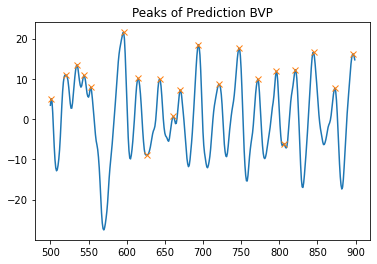

In [4]:

start_frame = 500
window_size = 400

plt.plot(df['pulse_pred'][start_frame:start_frame+window_size])
plt.plot([x for x in peaks_pred_indices if x > start_frame and x < start_frame+window_size], df['pulse_pred'][[x for x in peaks_pred_indices if x > start_frame and x < start_frame+window_size]], "x")
plt.title("Peaks of Prediction BVP")
plt.show()

In [5]:
df.head()

,time,pulse_pred,peaks_pred,p1,p2,p3
0,0.347012,0.0,False,129.702875,4.580894,48.553344
1,0.374532,0.0,False,130.236992,4.528492,49.087740
2,0.585289,0.0,False,129.942026,4.460915,48.874320
3,0.616227,0.0,False,130.180968,4.461329,48.991952
4,0.638510,0.0,False,129.841914,4.420334,48.785655


length IBIs: 44
length IBIs filtered: 44
mean IBIs:  697.6744186046511
std IBIs:  120.05187345239169
filter max:  817.7262920570428
filter min:  577.6225451522595


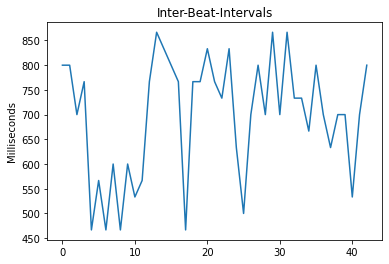

no filter:  29999.999999999996
with filter:  29999.999999999996


In [6]:
IBIs_filtered = calculate_IBIs(peaks=df['peaks_pred'], frame_rate=30, filter_width=1)
IBIs = calculate_IBIs(peaks=df['peaks_pred'], frame_rate=30, filter_width=1)
print("length IBIs:", len(IBIs))
print("length IBIs filtered:", len(IBIs_filtered))
mean_IBIs = mean(IBIs_filtered[1:])
stdev_IBIs = stdev(IBIs_filtered[1:])
print('mean IBIs: ', mean_IBIs)
print('std IBIs: ', stdev_IBIs)

print('filter max: ', mean_IBIs + 1 * stdev_IBIs)
print('filter min: ', mean_IBIs - 1 * stdev_IBIs)
plt.plot(IBIs_filtered[1:])
plt.title("Inter-Beat-Intervals")
plt.ylabel('Milliseconds')
plt.show()
print("no filter: ", sum(IBIs[1:]))
print("with filter: ", sum(IBIs_filtered[1:]))

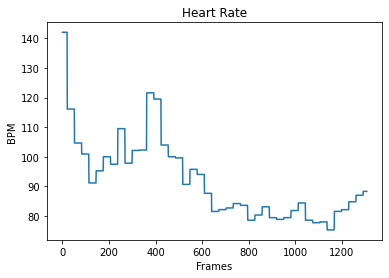

91.87791393706608

In [7]:
HR = calculate_HR(peaks=df['peaks_pred'], win_size=10, frame_rate=30, stride=30)
plt.plot(HR[320:])
plt.title("Heart Rate")
plt.ylabel('BPM')
plt.xlabel('Frames')
plt.show()
mean(HR[320:])

In [8]:
import pandas as pd

gt_df = pd.read_csv("my_groundtruth/1/1/data.txt")
print(gt_df.head())

   Unnamed: 0  time_ms   peak
0       30000    30000  False
1       30001    30001  False
2       30002    30002  False
3       30003    30003  False
4       30004    30004  False


In [9]:
from numpy import genfromtxt
from pulse_comparison import *

gt_1_1 = genfromtxt("my_groundtruth/Participant1_1.csv", delimiter=',')
participant2_start_times = ["01:00:30:00", "01:01:54:00", "01:03:24:00", "01:04:54:00", "01:06:36:00", "01:08:12:00", "01:09:50:00", "01:11:28:00", "01:12:54:00", "01:14:20:00"]
gt_1_1 = gt_1_1[1:]

participant1_start_times_ms = [read_timecode(i) for i in participant2_start_times]
slices = split_IBIS(gt_1_1, participant1_start_times_ms)

gt_IBIs = slices[7]

print('mean IBIs: ', mean(gt_IBIs))
print('std IBIs: ', stdev(gt_IBIs))

print(len(gt_IBIs))

mean IBIs:  823.4931506849315
std IBIs:  47.963273938293206
73


In [10]:
#mae calculation: if pred had less samples, spread out pred evenly to cover timeline of gt and then interpolate pred and get len(time_gt) samples for pred
#in calculate_IBIs -> Connect IBIs to a timeline and add zeros if IBI is removed, then later repeat HR value whenever IBI was removed
#Go to old pipeline, and compare HR_calculator with HR_calcualtor_IBIs
#in pulse_comparison, I use fixed video_length in ms as 60000 -> INCORRECT
#why is IBIs shorter than slices[0]
#peak detection sucks
#all gt slices of one participant are the same (the first one)
#videos are different lengths
print(sum(gt_IBIs))
print(sum(IBIs))
print(len(IBIs))

60115.0
30533.33333333333
44


In [11]:
HR_gt, time_gt = calculate_HR_with_IBIs(IBIs=gt_IBIs, win_size=10, frame_rate=30, stride_ms=500)

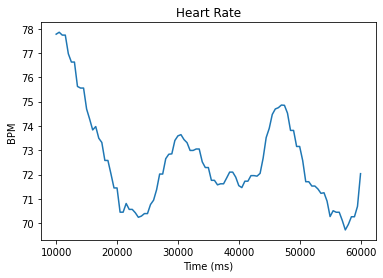

In [12]:
plt.plot(time_gt, HR_gt)
plt.title("Heart Rate")
plt.xlabel('Time (ms)')
plt.ylabel('BPM')
plt.show()

In [13]:
len(gt_IBIs)

73

In [14]:
HR_pred, time_pred = calculate_HR_with_IBIs(IBIs=np.asarray(IBIs), win_size=10, frame_rate=30, stride_ms=500)

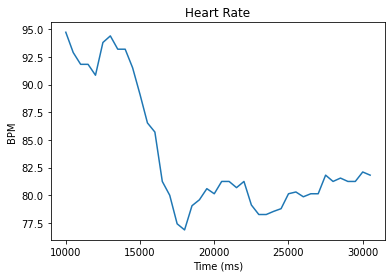

In [15]:
plt.plot(time_pred, HR_pred)
plt.title("Heart Rate")
plt.xlabel('Time (ms)')
plt.ylabel('BPM')
plt.show()

In [16]:

print(time_gt[-1])
print(time_pred[-1])
print(sum(IBIs))
print(sum(gt_IBIs))
print(len(IBIs))
print(len(time_pred))
print(len(gt_IBIs))
print(len(HR_pred))
print(len(HR_gt))

#find way to cut them to same lenght -> use  time_pred

60000
30500
30533.33333333333
60115.0
44
42
73
42
101


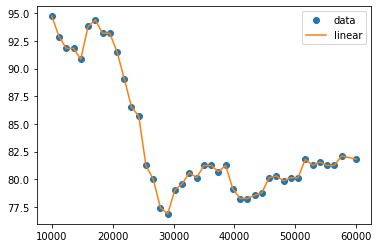

[94.73684210526315, 93.96641508895577, 93.1959880726484, 92.62540039057096, 92.17729488108607, 91.83673469387755, 91.83673469387755, 91.83673469387755, 91.48081044044476, 91.0669450294764, 91.44857667684055, 92.69199680406487, 93.83605472894608, 94.0858528327392, 94.33565093653233, 94.04205160915612, 93.53713105854739, 93.20388349514563, 93.20388349514563, 93.20388349514563, 92.52685770704531, 91.82162251110746, 90.93652564230929, 89.92118411385363, 88.89290674380948, 87.81288600741134, 86.7328652710132, 86.25450180072028, 85.9082094376212, 84.88895558223288, 83.01320528211285, 81.21848739495799, 80.69327731092437, 80.16806722689076, 79.26267281105991, 78.17836812144213, 77.34989759880534, 77.11837346579085, 76.88684933277638, 77.71323014153242, 78.63160268435546, 79.17607197319082, 79.40203108270335, 79.65941173910929, 80.08175551670561, 80.50409929430194, 80.44624924187626, 80.25295990405976, 80.32404742719007, 80.79170024174054, 81.25, 81.25, 81.25, 81.09931903796002, 80.86388003477

In [17]:
from scipy.interpolate import interp1d
new_time_pred = strech_HR_pred(time_gt, time_pred)
f = interp1d(new_time_pred, HR_pred)

plt.plot(new_time_pred, HR_pred, 'o', new_time_pred, f(new_time_pred))
plt.legend(['data', 'linear'], loc='best')
plt.show()

resampled_HR_pred = []
for time in time_gt:
    HR = f(time)
    HR = HR.tolist()
    resampled_HR_pred.append(HR)
print(resampled_HR_pred)
print(len(HR_gt))
print(len(resampled_HR_pred))
print(type(resampled_HR_pred[0]))

<class 'list'>
<class 'list'>


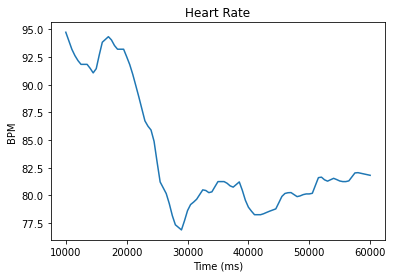

In [18]:
new_HR_pred = resample_HR_pred(time_gt, time_pred, HR_pred)


print(type(HR_pred))
print(type(new_HR_pred))

plt.plot(time_gt, new_HR_pred)
plt.title("Heart Rate")
plt.xlabel('Time (ms)')
plt.ylabel('BPM')
plt.show()

In [19]:
compute_MAE_HR_2(HR_gt, new_HR_pred)

10.981448179150375

In [20]:
from post_pipeline import *
HR_pred, HR_gt, time, mae, std = run_post_pipeline(participant=3, condition=8, win_size=10, stride_ms=500, frame_rate=30)

MAE:   12.214876084984954
STD:   (5.787196323557865, [2.442669655784414, 2.442669655784414, 2.2188898521521025, 2.4214357206599146, 2.8510456881881936, 2.817846749853288, 3.2024714279491207, 2.9527849323369395, 2.9527849323369395, 2.4454827252763067, 2.4454827252763067, 1.401579467753578, 1.477431542554342, 1.5532836173551061, 1.487747424727246, 2.6020069228864458, 2.245772278711158, 2.3303949584763046, 2.3332956293683793, 3.576226135867472, 4.151705116503848, 4.917131655914858, 5.590267969112475, 6.429834408123575, 7.272922054765189, 7.970500018581127, 7.642356556975393, 9.101566607452355, 9.202687067087538, 10.57965095899295, 10.8066739609635, 11.400768309926711, 11.400768309926711, 11.826315915732351, 12.05658210344535, 12.732381897286771, 13.769428388878708, 15.117781021420107, 15.144744230201503, 14.958361885736181, 15.090063835619944, 15.230576753284481, 15.403534524752956, 15.662112635570445, 15.967697054475316, 16.429954951277217, 16.775692672947223, 16.688452607951994, 16.6785

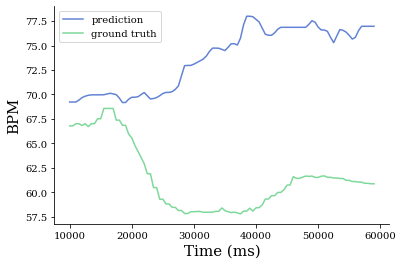

In [21]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.plot(time, HR_pred, label='prediction', c="#6182D5")
plt.plot(time, HR_gt, label='ground truth', c="#7DD89A")
plt.legend()
#["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
plt.xlabel('Time (ms)')
plt.ylabel('BPM')

plt.savefig('/Users/etienne/Downloads/plot_hear_rates_3_8.pdf', bbox_inches='tight')

std2, distances = compute_std(HR_pred, HR_gt, mae)
print("MAE:  ", mae)
print("STD:  ", compute_std(HR_pred, HR_gt, mae))
print("Distances:  ", distances)

ü

In [22]:
from post_pipeline import *
participants_mae = []
participants_std = []
for participant in range(1,6):
    conditions_mae = []
    conditions_std = []
    for condition in range(1,14):
        HR_pred, HR_gt, time, mae, std = run_post_pipeline(participant=participant, condition=condition, win_size=10, stride_ms=500, frame_rate=30)
        conditions_mae.append(mae)
        conditions_std.append(std)
    participants_mae.append(conditions_mae)
    participants_std.append(conditions_std)
print(participants_mae)
print(participants_std)

[[11.55461029958408, 5.465829278956062, 4.993191257740424, 4.962996123129395, 5.89004824334229, 6.043447288918866, 7.614613361655044, 7.290774754027551, 4.298815531731165, 5.628003999755897, 10.577481183145473, 18.468630991577292, 37.151225325914254], [8.35281601578172, 12.151238983013458, 4.201192710288811, 7.825366177003285, 9.314960909320286, 15.7755162080103, 11.385552531461487, 6.253377132542003, 4.00493641479527, 6.064505647402182, 28.631977620321067, 22.761776654027248, 25.360775349488023], [12.65975394490959, 14.109319589715817, 6.15731446472489, 3.5416409959019046, 12.996974933288332, 16.663442158194055, 4.666345864188249, 12.214876084984954, 14.139999135807319, 13.62365005821017, 5.978166820080908, 40.06887868025741, 59.98637781232639], [7.479665598850633, 11.526615332085568, 8.242625700107546, 13.48113066065271, 16.384734633061516, 5.717691718792479, 15.984439521550241, 9.297949845975364, 7.185046949748783, 10.176302798153195, 4.6602274337274165, 28.078582771863356, 53.26571

In [23]:
mae_df = pd.DataFrame(participants_mae)
mae_df.columns = ["Condition " + str(x)  for x in range(1, 14)]
mae_df.rows = ["Participant " + str(x)  for x in range(1, 6)]
mae_df

/var/folders/gw/mdnt8vy92t313yblt6ndnvgh0000gn/T/ipykernel_165/3951818257.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  mae_df.rows = ["Participant " + str(x)  for x in range(1, 6)]


,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Condition 8,Condition 9,Condition 10,Condition 11,Condition 12,Condition 13
0,11.554610,5.465829,4.993191,4.962996,5.890048,6.043447,7.614613,7.290775,4.298816,5.628004,10.577481,18.468631,37.151225
1,8.352816,12.151239,4.201193,7.825366,9.314961,15.775516,11.385553,6.253377,4.004936,6.064506,28.631978,22.761777,25.360775
2,12.659754,14.109320,6.157314,3.541641,12.996975,16.663442,4.666346,12.214876,14.139999,13.623650,5.978167,40.068879,59.986378
3,7.479666,11.526615,8.242626,13.481131,16.384735,5.717692,15.984440,9.297950,7.185047,10.176303,4.660227,28.078583,53.265715
4,4.161162,7.168149,7.231926,11.482901,24.317894,22.884741,6.616987,5.177706,11.107170,13.269120,8.169048,18.649914,41.680850


In [24]:
std_df = pd.DataFrame(participants_std)
std_df.columns = ["Condition " + str(x)  for x in range(1, 14)]
std_df.rows = ["Participant " + str(x)  for x in range(1, 6)]
std_df

/var/folders/gw/mdnt8vy92t313yblt6ndnvgh0000gn/T/ipykernel_165/2354537804.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  std_df.rows = ["Participant " + str(x)  for x in range(1, 6)]


,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Condition 8,Condition 9,Condition 10,Condition 11,Condition 12,Condition 13
0,4.759708,1.728821,1.687164,2.318776,2.221437,3.864344,4.811987,2.842207,1.751609,3.926276,2.195350,4.346174,6.710173
1,4.482100,4.186720,1.728804,3.863754,2.374721,6.604131,5.514152,4.263514,2.704406,2.107172,7.076144,4.938920,3.073502
2,3.026132,5.531979,2.696270,4.452041,2.130131,4.089007,3.033176,5.787196,2.343086,4.027265,1.635283,5.769677,9.586316
3,2.312861,2.946012,2.987582,3.864409,4.989451,1.661814,4.651150,4.528865,2.021369,5.072369,2.341011,5.894068,5.356808
4,2.189559,2.855049,3.856984,5.801613,6.632006,8.378793,3.059044,2.576408,2.837427,3.880114,3.063348,7.267012,5.157393


In [25]:
mae_df.describe()

,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Condition 8,Condition 9,Condition 10,Condition 11,Condition 12,Condition 13
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,8.841602,10.084230,6.165250,8.258807,13.780923,13.416968,9.253588,8.046937,8.147194,9.752317,11.603380,25.605557,43.488989
std,3.388916,3.618961,1.634365,4.212165,7.082247,7.405888,4.486935,2.781990,4.403669,3.812637,9.780984,8.982028,13.599788
min,4.161162,5.465829,4.201193,3.541641,5.890048,5.717692,4.666346,5.177706,4.004936,5.628004,4.660227,18.468631,25.360775
25%,7.479666,7.168149,4.993191,4.962996,9.314961,6.043447,6.616987,6.253377,4.298816,6.064506,5.978167,18.649914,37.151225
50%,8.352816,11.526615,6.157314,7.825366,12.996975,15.775516,7.614613,7.290775,7.185047,10.176303,8.169048,22.761777,41.680850
75%,11.554610,12.151239,7.231926,11.482901,16.384735,16.663442,11.385553,9.297950,11.107170,13.269120,10.577481,28.078583,53.265715
max,12.659754,14.109320,8.242626,13.481131,24.317894,22.884741,15.984440,12.214876,14.139999,13.623650,28.631978,40.068879,59.986378


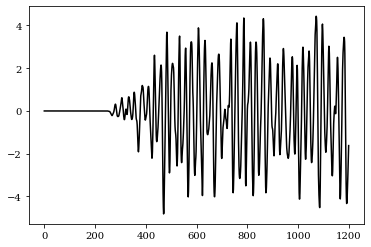

In [26]:
path = "my_signals/2/3/data.csv"
signal_pred_df = pd.read_csv(path)
signal_pred_df['p3']

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(signal_pred_df['p0'][:1200], label='prediction', c="black")

plt.savefig('/Users/etienne/Downloads/signal_pos.pdf', bbox_inches='tight')

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])
poly_features = poly.fit_transform(x.reshape(-1, 1))

color_complete_df[["MAE", "Condition"]]


NameError: name 'color_complete_df' is not defined

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, color_complete_df["MAE"], sample_weight=color_complete_df["STD"])
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted[0:25:5]
print(y_predicted)

In [ ]:
x_predicted = np.arange(0,6)
print(x_predicted)

In [ ]:
#std_df.iloc[:,:5].max()
max(color_df["STD"].tolist())

In [ ]:
x = complete_df.loc[complete_df['Condition'] < 6]
x = x.sort_values('Condition')
print(x)
x = x["Participant"].tolist()
x = [int(item) for item in x]
print(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as pp
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.scatter(complete_df['MAE'], np.zeros_like(complete_df['MAE']) + val, s=80, c="#6182D5", edgecolors='none', alpha=0.2)
plt.xlabel('Mean Absolute Error [BPM]')
ax.xaxis.get_label().set_fontsize(15)
plt.savefig('/Users/etienne/Downloads/plot_summary.pdf', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from post_pipeline import *
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

color_df = complete_df.loc[complete_df['Condition'] < 6].sort_values('Condition')
max_std = max(color_df["STD"].tolist())
poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])
poly_features = poly.fit_transform(x.reshape(-1, 1))
color_df[["MAE", "Condition"]]
linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, color_df["MAE"], sample_weight=max_std-color_df['STD']+1)
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted[0:25:5]
print(y_predicted)

colums_df = ([1]*5)+([2]*5)+([3]*5)+([4]*5)+([5]*5)
factor = 2.6
x_predicted = np.arange(1,6)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
color_df = complete_df.loc[complete_df['Condition'] < 6].sort_values('Condition')
c =  color_df["Participant"].tolist()
c = [int(item) for item in c]
colors = get_colors(c)
colors = ["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, max(c)+2), colors)

scatter = ax.scatter(colums_df, color_df['MAE'], s=(max_std-color_df['STD']+3)**factor, c=c, cmap=cmap, norm=norm, alpha=0.8)

#scatter = ax.scatter(colums_df, mae_df.iloc[0, 0:5], s=(max_std-(std_df.iloc[0, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[1, 0:5], s=(max_std-(std_df.iloc[1, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[2, 0:5], s=(max_std-(std_df.iloc[2, 0:5])+2)**factor, c=[3, 3, 3, 3, 3])
#scatter = ax.scatter(colums_df, mae_df.iloc[3, 0:5], s=(max_std-(std_df.iloc[3, 0:5])+2)**factor, c=[4, 4, 4, 4, 4])
#scatter = ax.scatter(colums_df, mae_df.iloc[4, 0:5], s=(max_std-(std_df.iloc[4, 0:5])+2)**factor, c=[5, 5, 5, 5, 5])

legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Participant")



plt.plot(x_predicted, y_predicted, color="black", linewidth=2.5)
plt.xlabel('Color Temperature [Kelvin]')
plt.ylabel('Mean Absolute Error [BPM]')
plt.xticks(np.arange(1, 6, step=1))
ax.set_xticklabels(["1700", "2900", "4100", "5300", "6500"])
#plt.show()
plt.legend(*scatter.legend_elements(), loc="upper left", title="Participant", bbox_to_anchor=(1, 1))
plt.savefig('/Users/etienne/Downloads/plot_color_weighted.pdf', bbox_inches='tight')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from post_pipeline import *
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

color_complete_df = complete_df.loc[complete_df['Condition'] < 6].sort_values('Condition')

poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])
poly_features = poly.fit_transform(x.reshape(-1, 1))
color_complete_df[["MAE", "Condition"]]
linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, color_complete_df["MAE"])
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted[0:25:5]
print(y_predicted)

colums_df = ([1]*5)+([2]*5)+([3]*5)+([4]*5)+([5]*5)
factor = 2.3
x_predicted = np.arange(1,6)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
color_df = complete_df.loc[complete_df['Condition'] < 6].sort_values('Condition')
max_std = max(color_df["STD"].tolist())
c =  color_df["Participant"].tolist()
c = [int(item) for item in c]
colors = get_colors(c)
colors = ["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, max(c)+2), colors)

scatter = ax.scatter(colums_df, color_df['MAE'], s=70, c=c, cmap=cmap, norm=norm, alpha=0.8)

#scatter = ax.scatter(colums_df, mae_df.iloc[0, 0:5], s=(max_std-(std_df.iloc[0, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[1, 0:5], s=(max_std-(std_df.iloc[1, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[2, 0:5], s=(max_std-(std_df.iloc[2, 0:5])+2)**factor, c=[3, 3, 3, 3, 3])
#scatter = ax.scatter(colums_df, mae_df.iloc[3, 0:5], s=(max_std-(std_df.iloc[3, 0:5])+2)**factor, c=[4, 4, 4, 4, 4])
#scatter = ax.scatter(colums_df, mae_df.iloc[4, 0:5], s=(max_std-(std_df.iloc[4, 0:5])+2)**factor, c=[5, 5, 5, 5, 5])

legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Participant")



plt.plot(x_predicted, y_predicted, color="black", linewidth=2.5)
plt.xlabel('Color Temperature [Kelvin]')
plt.ylabel('Mean Absolute Error [BPM]')
plt.xticks(np.arange(1, 6, step=1))
ax.set_xticklabels(["1700", "2900", "4100", "5300", "6500"])
#plt.show()
plt.legend(*scatter.legend_elements(), loc="upper left", title="Participant", bbox_to_anchor=(1, 1))
plt.savefig('/Users/etienne/Downloads/plot_color_not_weighted.pdf', bbox_inches='tight')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from post_pipeline import *
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
brightness_df = complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)].sort_values('Condition')
max_std = max(brightness_df["STD"].tolist())
poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])
poly_features = poly.fit_transform(x.reshape(-1, 1))
brightness_df[["MAE", "Condition"]]
linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, brightness_df["MAE"], sample_weight=max_std-brightness_df["STD"]+1)
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted[0:25:5]
print(y_predicted)

colums_df = ([1]*5)+([2]*5)+([3]*5)+([4]*5)+([5]*5)
factor = 2.6
x_predicted = np.arange(1,6)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

c =  brightness_df["Participant"].tolist()
c = [int(item) for item in c]
colors = get_colors(c)
colors = ["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, max(c)+2), colors)

scatter = ax.scatter(colums_df, brightness_df['MAE'], s=(max_std-brightness_df['STD']+3)**factor, c=c, cmap=cmap, norm=norm, alpha=0.8)

#scatter = ax.scatter(colums_df, mae_df.iloc[0, 0:5], s=(max_std-(std_df.iloc[0, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[1, 0:5], s=(max_std-(std_df.iloc[1, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[2, 0:5], s=(max_std-(std_df.iloc[2, 0:5])+2)**factor, c=[3, 3, 3, 3, 3])
#scatter = ax.scatter(colums_df, mae_df.iloc[3, 0:5], s=(max_std-(std_df.iloc[3, 0:5])+2)**factor, c=[4, 4, 4, 4, 4])
#scatter = ax.scatter(colums_df, mae_df.iloc[4, 0:5], s=(max_std-(std_df.iloc[4, 0:5])+2)**factor, c=[5, 5, 5, 5, 5])

legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Participant")



plt.plot(x_predicted, y_predicted, color="black", linewidth=2.5)
plt.xlabel('Luminance [Lux]')
plt.ylabel('Mean Absolute Error [BPM]')
plt.xticks(np.arange(1, 6, step=1))
ax.set_xticklabels(["60", "120", "180", "240", "300"])
#plt.show()
plt.legend(*scatter.legend_elements(), loc="upper left", title="Participant", bbox_to_anchor=(1, 1))
plt.savefig('/Users/etienne/Downloads/plot_lum_weighted.pdf', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from post_pipeline import *
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
brightness_complete_df = complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)].sort_values('Condition')
poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])
poly_features = poly.fit_transform(x.reshape(-1, 1))
brightness_complete_df[["MAE", "Condition"]]
linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, brightness_complete_df["MAE"])
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted[0:25:5]
print(y_predicted)

colums_df = ([1]*5)+([2]*5)+([3]*5)+([4]*5)+([5]*5)
factor = 2.3
x_predicted = np.arange(1,6)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
brightness_df = complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)].sort_values('Condition')
max_std = max(brightness_df["STD"].tolist())
c =  brightness_df["Participant"].tolist()
c = [int(item) for item in c]
colors = get_colors(c)
colors = ["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, max(c)+2), colors)

scatter = ax.scatter(colums_df, brightness_df['MAE'], s=70, c=c, cmap=cmap, norm=norm, alpha=0.8)

#scatter = ax.scatter(colums_df, mae_df.iloc[0, 0:5], s=(max_std-(std_df.iloc[0, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[1, 0:5], s=(max_std-(std_df.iloc[1, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[2, 0:5], s=(max_std-(std_df.iloc[2, 0:5])+2)**factor, c=[3, 3, 3, 3, 3])
#scatter = ax.scatter(colums_df, mae_df.iloc[3, 0:5], s=(max_std-(std_df.iloc[3, 0:5])+2)**factor, c=[4, 4, 4, 4, 4])
#scatter = ax.scatter(colums_df, mae_df.iloc[4, 0:5], s=(max_std-(std_df.iloc[4, 0:5])+2)**factor, c=[5, 5, 5, 5, 5])

legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Participant")



plt.plot(x_predicted, y_predicted, color="black", linewidth=2.5)
plt.xlabel('Luminance [Lux]')
plt.ylabel('Mean Absolute Error [BPM]')
plt.xticks(np.arange(1, 6, step=1))
ax.set_xticklabels(["60", "120", "180", "240", "300"])
#plt.show()
plt.legend(*scatter.legend_elements(), loc="upper left", title="Participant", bbox_to_anchor=(1, 1))
plt.savefig('/Users/etienne/Downloads/plot_lum_not_weighted.pdf', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from post_pipeline import *
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

direction_df = complete_df.loc[complete_df['Condition'] > 10].sort_values('Condition')
max_std = max(direction_df["STD"].tolist())

poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])
poly_features = poly.fit_transform(x.reshape(-1, 1))
direction_df[["MAE", "Condition"]]
linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, direction_df["MAE"], sample_weight=max_std-direction_df["STD"]+1)
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted[0:15:5]
print(y_predicted)

colums_df = ([1]*5)+([2]*5)+([3]*5)
factor = 2.6
x_predicted = np.arange(1,4)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

c =  direction_df["Participant"].tolist()
c = [int(item) for item in c]
colors = get_colors(c)
colors = ["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, max(c)+2), colors)

scatter = ax.scatter(colums_df, direction_df['MAE'], s=(max_std-direction_df['STD']+3)**factor, c=c, cmap=cmap, norm=norm, alpha=0.8)

#scatter = ax.scatter(colums_df, mae_df.iloc[0, 0:5], s=(max_std-(std_df.iloc[0, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[1, 0:5], s=(max_std-(std_df.iloc[1, 0:5])+2)**factor, c=[1, 1, 1, 1, 1])
#scatter = ax.scatter(colums_df, mae_df.iloc[2, 0:5], s=(max_std-(std_df.iloc[2, 0:5])+2)**factor, c=[3, 3, 3, 3, 3])
#scatter = ax.scatter(colums_df, mae_df.iloc[3, 0:5], s=(max_std-(std_df.iloc[3, 0:5])+2)**factor, c=[4, 4, 4, 4, 4])
#scatter = ax.scatter(colums_df, mae_df.iloc[4, 0:5], s=(max_std-(std_df.iloc[4, 0:5])+2)**factor, c=[5, 5, 5, 5, 5])

legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Participant")



plt.plot(x_predicted, y_predicted, color="black", linewidth=2.5)
plt.xlabel('Direction [Degrees]')
plt.ylabel('Mean Absolute Error [BPM]')
plt.xticks(np.arange(1, 4, step=1))
ax.set_xticklabels(["0", "45", "90"])
#plt.show()
plt.legend(*scatter.legend_elements(), loc="upper left", title="Participant", bbox_to_anchor=(1, 1))
plt.savefig('/Users/etienne/Downloads/plot_direction_weighted.pdf', bbox_inches='tight')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
brightness_complete_df = complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)]
poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.asarray([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])
poly_features = poly.fit_transform(x.reshape(-1, 1))
brightness_complete_df[["MAE", "Condition"]].
linear_reg_model = LinearRegression()
linear_reg_model.fit(poly_features, brightness_complete_df["MAE"], sample_weight=brightness_complete_df["STD"])
y_predicted = linear_reg_model.predict(poly_features)
y_predicted = y_predicted
print(y_predicted)

In [ ]:
x=complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)]
x[["MAE", "Condition"]]

In [ ]:
mae_df.iloc[:, 0:5]

In [ ]:
from post_pipeline import *
mae_list = []
std_list = []
conditions = []
participants = []
for participant in range(1,6):
    for condition in range(1,14):
        HR_pred, HR_gt, time, mae, std = run_post_pipeline(participant=participant, condition=condition, win_size=10, stride_ms=500, frame_rate=30)
        mae_list.append(mae)
        std_list.append(std)
        conditions.append(condition)
        participants.append(participant)
participants = [str(x) for x in participants]
complete_df = pd.DataFrame(list(zip(mae_list, std_list, conditions, participants)),
               columns =['MAE', 'STD', 'Condition', 'Participant'])

In [ ]:
complete_df

In [ ]:
(11+5+5+5+6+6+7.6+7.2+4+10+19+37)/12

In [ ]:
skin_colors_per_participant = [21, 21, 23, 26, 19]
MAE_per_participant = complete_df.groupby(['Participant'])['MAE'].mean()
print(MAE_per_participant)
skin_color_axis = range(0,31)
plt.figure(figsize=(8, 6))
ax = plt.subplot()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

c =  direction_df["Participant"].tolist()
c = range(1, 6)
colors = ["#CC665C", "#C0DA6B", "#7DD89A", "#6182D5", "#BB5ED4"]
cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, max(c)+2), colors)

scatter = ax.scatter(skin_colors_per_participant, MAE_per_participant,s=80, c=c, cmap=cmap, alpha=0.8)

plt.xlabel('Fitzpatrick Scale [Score]')
plt.ylabel('Mean Absolute Error [BPM]')
plt.legend(*scatter.legend_elements(), loc="upper left", title="Participant", bbox_to_anchor=(1, 1))
plt.savefig('/Users/etienne/Downloads/plot_skin_color.pdf', bbox_inches='tight')



In [ ]:
from plotnine import ggplot, aes, geom_point, geom_smooth, geom_line
color_complete_df = complete_df.loc[complete_df['Condition'] < 6]
(
        ggplot(color_complete_df)  # What data to use
        + aes(x="Condition", y="MAE", color="Participant",  size="STD")  # What variable to use
        + geom_point()  # Geometric object to use for drawing


)

In [ ]:
y_predicted

In [ ]:
luminance_complete_df = complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)]
STD = luminance_complete_df["STD"]
MAE = luminance_complete_df["MAE"]
(
        ggplot(luminance_complete_df)  # What data to use
        + aes(x="Condition", y="MAE",  size=STD, weight=STD)  # What variable to use
        + geom_point()  # Geometric object to use for drawing
        + geom_smooth(method = "lm", mapping=aes(weight=STD))
)

In [ ]:
luminance_complete_df = complete_df.loc[(5 < complete_df['Condition']) & (complete_df['Condition'] < 11)]

(
        ggplot(luminance_complete_df)  # What data to use
        + aes(x="Condition", y="MAE",  size="STD")  # What variable to use
        + geom_point()  # Geometric object to use for drawing
        + geom_smooth(method = "lm")
)

In [ ]:
luminance_complete_df = complete_df.loc[(10 < complete_df['Condition']) & (complete_df['Condition'] < 14)]

(
        ggplot(luminance_complete_df)  # What data to use
        + aes(x="Condition", y="MAE", size="STD")  # What variable to use
        + geom_point()  # Geometric object to use for drawing
        + geom_smooth(method = "lm")
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colums_df = range(1,6)
y = mae_df.iloc[0, 0:5]
factor = 1.4

plt.scatter(colums_df, mae_df.iloc[0, 5:10], s=std_df.iloc[0, 5:10]**factor, color='pink')
plt.scatter(colums_df, mae_df.iloc[1, 5:10], s=std_df.iloc[1, 5:10]**factor, color='red')
plt.scatter(colums_df, mae_df.iloc[2, 5:10], s=std_df.iloc[2, 5:10]**factor, color='blue')
plt.scatter(colums_df, mae_df.iloc[3, 5:10], s=std_df.iloc[3, 5:10]**factor, color='green')
plt.scatter(colums_df, mae_df.iloc[4, 5:10], s=std_df.iloc[4, 5:10]**factor, color='orange')
plt.show()

In [ ]:
plt.show()
import matplotlib.pyplot as plt
import numpy as np

colums_df = range(1, 4)
y = mae_df.iloc[0, 0:5]
factor = 1.2

plt.scatter(colums_df, mae_df.iloc[0, 10:13], s=std_df.iloc[0, 10:13]**factor, color='pink')
plt.scatter(colums_df, mae_df.iloc[1, 10:13], s=std_df.iloc[0, 10:13]**factor, color='red')
plt.scatter(colums_df, mae_df.iloc[2, 10:13], s=std_df.iloc[0, 10:13]**factor, color='blue')
plt.scatter(colums_df, mae_df.iloc[3, 10:13], s=std_df.iloc[0, 10:13]**factor, color='green')
plt.scatter(colums_df, mae_df.iloc[4, 10:13], s=std_df.iloc[0, 10:13]**factor, color='orange')
plt.show()